In [1]:
import os
import sys

import matplotlib.pyplot as plt
from hydra import initialize, compose
from glob import glob
import pickle
import numpy as np
from tqdm import tqdm

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses import lens_util
from mejiro.plots import plot
from mejiro.utils import util
from mejiro.helpers import color

In [2]:
side = 4
start = 37
indices = range(start, start + (side ** 2))

In [3]:
def get_sample(pickle_dir, color_dir, index):
    # get lens
    lens_path = os.path.join(pickle_dir, f'lens_{str(index).zfill(8)}')
    lens = util.unpickle(lens_path)

    # get rgb model
    files = glob(pickle_dir + f'/array_{str(index).zfill(8)}_*')
    f106 = [np.load(i) for i in files if 'F106' in i][0]
    f129 = [np.load(i) for i in files if 'F129' in i][0]
    # f158 = [np.load(i) for i in files if 'F158' in i][0]
    f184 = [np.load(i) for i in files if 'F184' in i][0]
    rgb_model = color.get_rgb(f106, f129, f184, minimum=None, stretch=0.2, Q=8)

    # get rgb image
    image_path = os.path.join(color_dir, f'galsim_color_{str(index).zfill(8)}.npy')
    rgb_image = np.load(image_path)

    return lens, rgb_model, rgb_image

In [4]:
color_images, color_model_images = [], []

for index in tqdm(indices):
    lens, rgb_model, rgb_image = get_sample(config.machine.dir_03, config.machine.dir_05, index)
    color_images.append(rgb_image)
    color_model_images.append(rgb_model)
    # lens_path = os.path.join(config.machine.dir_05, f'galsim_color_{str(index).zfill(8)}.npy')
    # color_images.append(np.load(lens_path))

  6%|▋         | 1/16 [00:00<00:01,  9.92it/s]

100%|██████████| 16/16 [00:01<00:00, 10.67it/s]


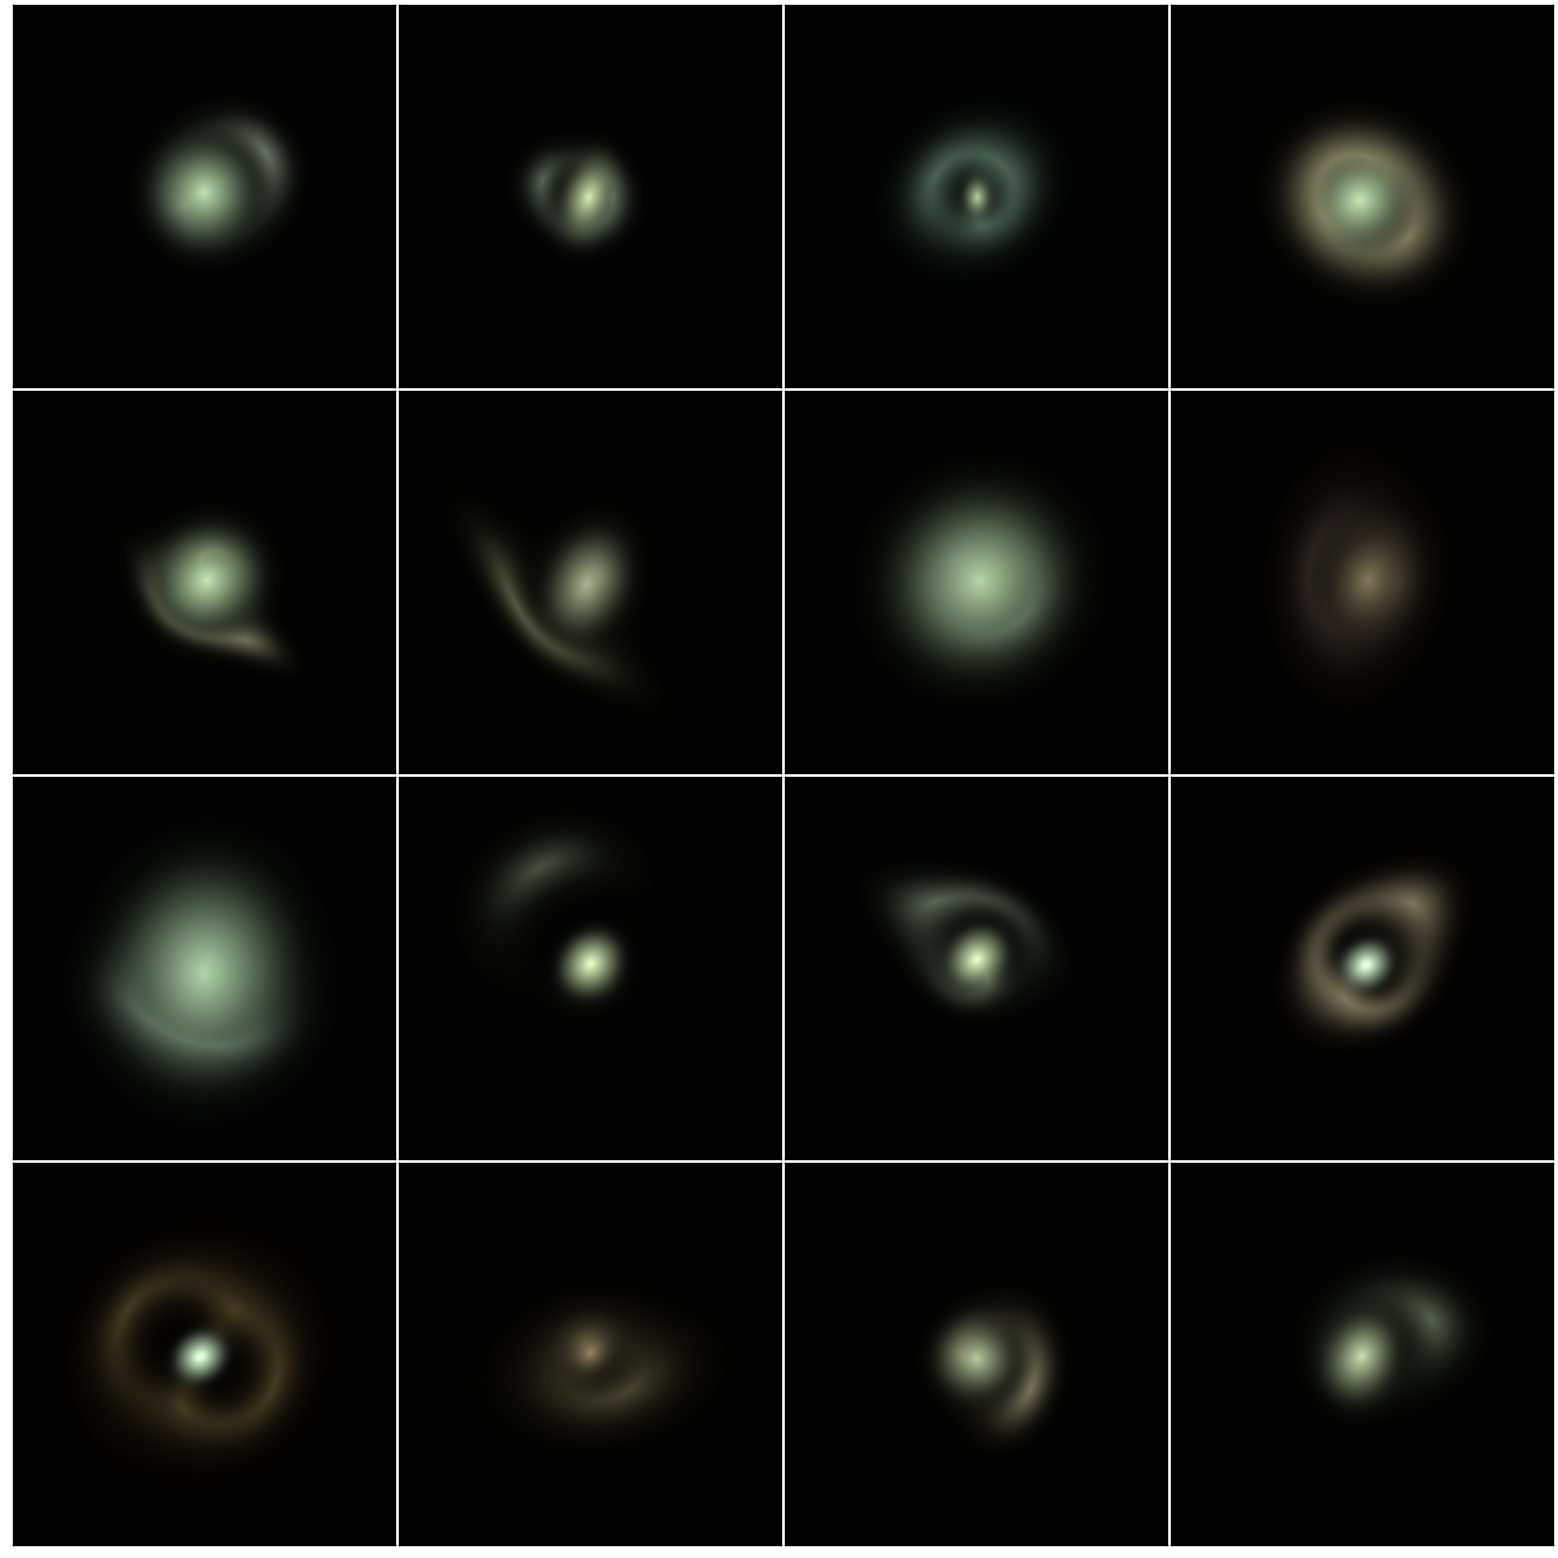

In [5]:
save_path = os.path.join(figure_dir, 'mosaic_models.png')
plot.plot_grid(color_model_images, side=side, log10=False, save=save_path)

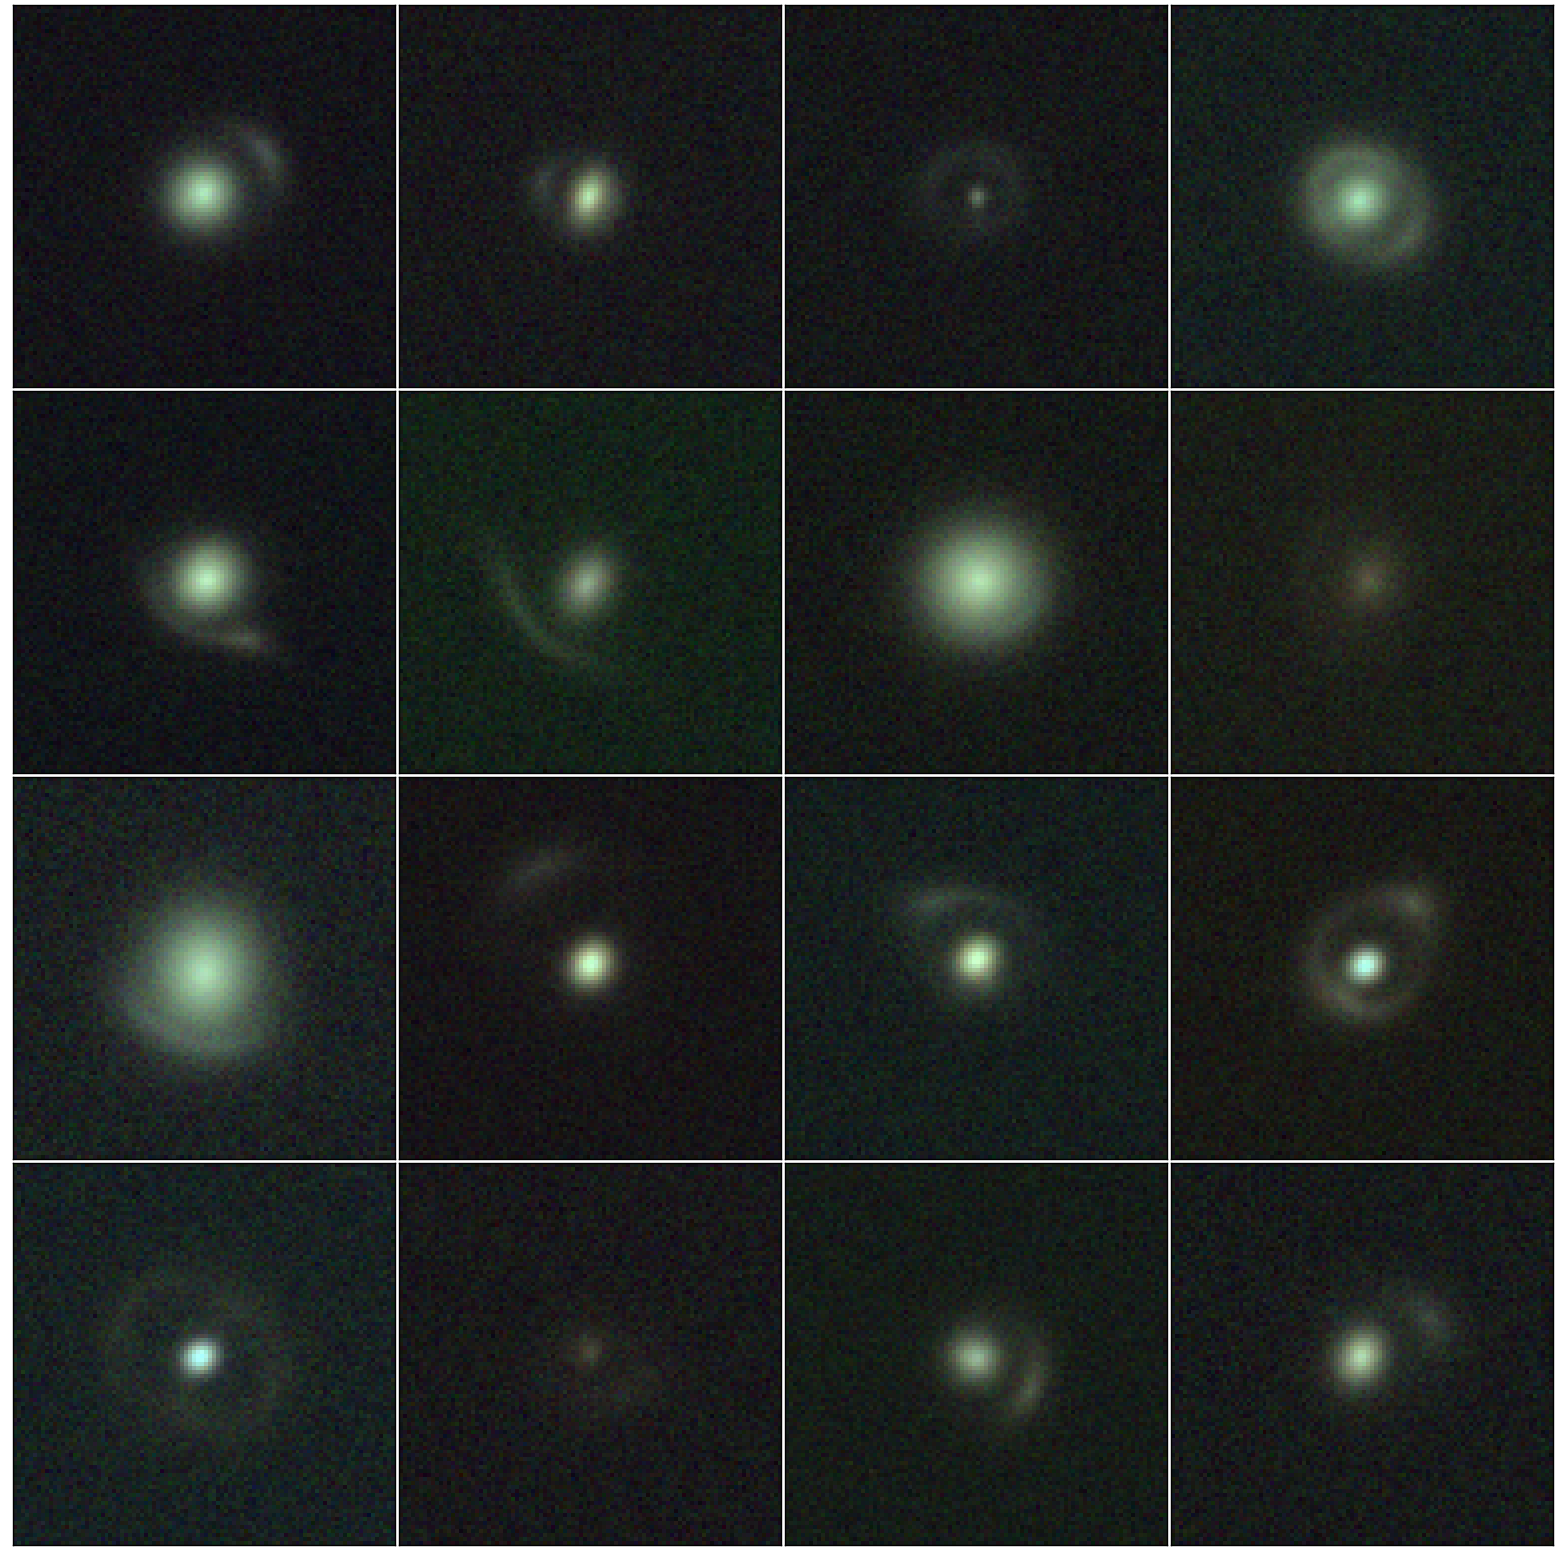

In [6]:
save_path = os.path.join(figure_dir, 'mosaic_galsim.png')
plot.plot_grid(color_images, side=side, log10=False, save=save_path)

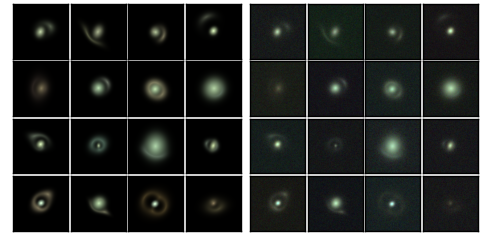

In [9]:
fig = plt.figure(figsize=(6, 6))
outer_grid = fig.add_gridspec(2, 2, wspace=0.04, hspace=0.04)

grid = 4

import random
np.random.seed(config.seed)
random_indices = random.sample(range(len(color_images)), grid ** 2)

model_subset = [color_model_images[i] for i in random_indices]
pandeia_subset = [color_images[i] for i in random_indices]

subsets = [model_subset, pandeia_subset]

for i, subset in enumerate(subsets):
    inner_grid = outer_grid[0, i].subgridspec(4, 4, wspace=0.04, hspace=0.04)
    ax = inner_grid.subplots()
    for i, image in enumerate(subset):
        ax[i // grid, i % grid].imshow(image)
        ax[i // grid, i % grid].get_xaxis().set_visible(False)
        ax[i // grid, i % grid].get_yaxis().set_visible(False)

plt.savefig(os.path.join(figure_dir, 'mosaic.png'))
plt.show()